# Cargando dependencias necesarias

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from prophet import Prophet

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('near-protocol_2020-05-11_2025-05-10.csv')

# Exploración

In [ ]:
print(df.index.inferred_freq)

D


<Axes: xlabel='Start'>

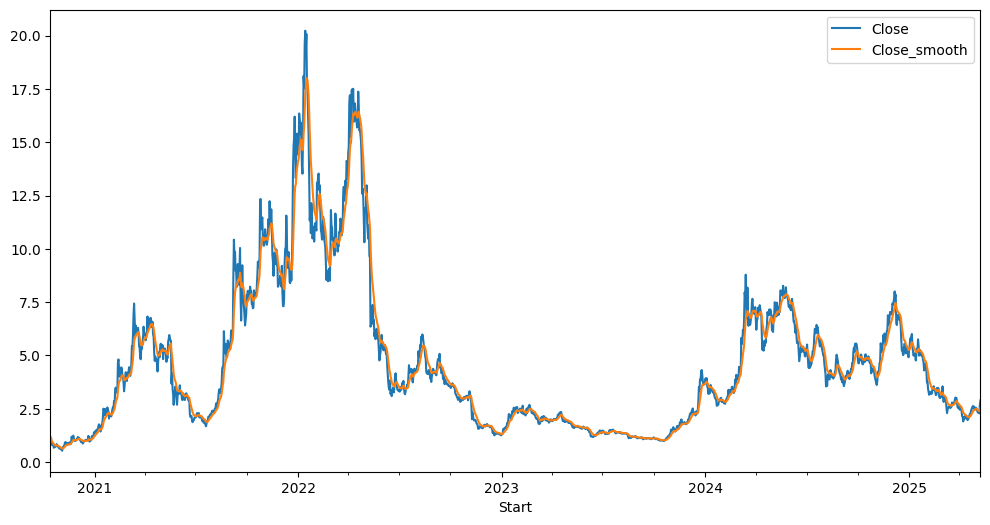

In [ ]:
df['Close_smooth'] = df['Close'].ewm(span=10).mean()
df[['Close', 'Close_smooth']].plot(figsize=(12,6))

In [5]:
df['Start'] = pd.to_datetime(df['Start'])
df = df.set_index('Start').sort_index()

# Experimento 3 - XGBOOST

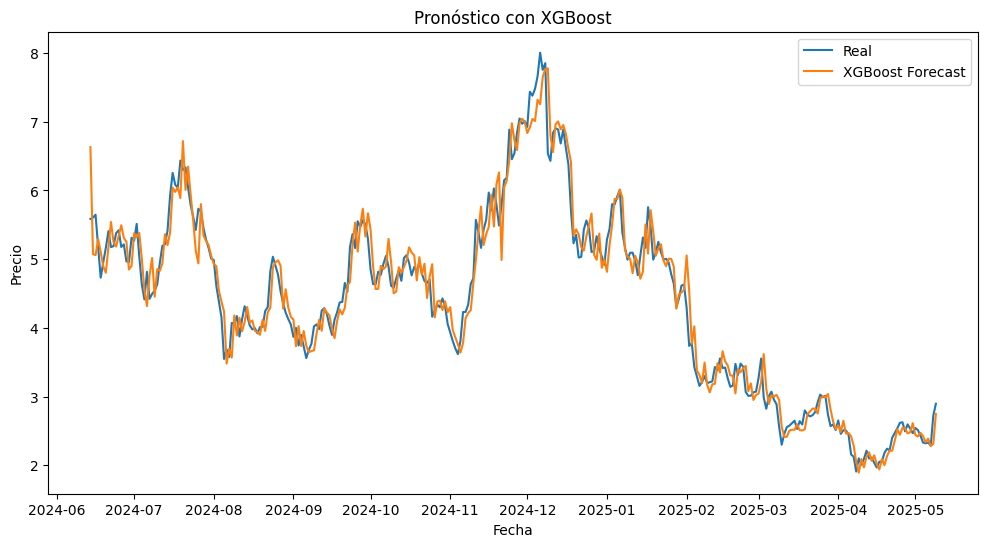

In [ ]:
# asegura orden temporal
df = df.sort_index()

# ========================
# Crear features
# ========================

# retornos
df['Return'] = df['Close'].pct_change()

# Lags del precio
df['Lag1'] = df['Close'].shift(1)
df['Lag2'] = df['Close'].shift(2)
df['Lag3'] = df['Close'].shift(3)

# Lags del volumen
df['Volume_Lag1'] = df['Volume'].shift(1)

# Rolling mean 
df['MA5'] = df['Close'].rolling(5).mean().shift(1)

# Dropear NaN generados por lags
df.dropna(inplace=True)

# ========================
# features y target
# ========================

features = ['Lag1', 'Lag2', 'Lag3', 'Volume_Lag1', 'MA5']
target = 'Close'

X = df[features]
y = df[target]

# ========================
# train/test
# ========================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ========================
# XGBoost
# ========================

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05
)

model.fit(X_train, y_train)

# ========================
# test
# ========================

y_pred = model.predict(X_test)

# ========================
# Visualizar
# ========================

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred, label='XGBoost Forecast')
plt.title('Pronóstico con XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()


In [15]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"XGBoost MAE: {mae:.4f}")
print(f"XGBoost RMSE: {rmse:.4f}")
print(f"XGBoost R²: {r2:.4f}")

XGBoost MAE: 0.2154
XGBoost RMSE: 0.2835
XGBoost R²: 0.9553


# Experimento 4 - SARIMAX + GARCH

In [17]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("La serie es estacionaria")
else:
    print("La serie NO es estacionaria (se necesita diferenciar)")

ADF Statistic: -3.0545877837932873
p-value: 0.030101582554879255
La serie es estacionaria


In [9]:
# variable dependiente
y = df['Close']

# exógenas 
exog = df[['Volume', 'Lag1', 'Lag2']]  

# alineación
print(y.index.equals(exog.index))  # True → bien

True


In [ ]:
import itertools
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = P = D = Q = [0, 1]
s = 7  # estacionalidad semanal

results = []

for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                y,
                exog=exog,
                order=order,
                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False)
            results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'AIC': res.aic
            })
            print(f'✔️ {order} x {seasonal_order} AIC: {res.aic:.2f}')
        except Exception as e:
            print(f'❌ {order} x {seasonal_order} falló: {e}')

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('AIC')
print('\nMejores combinaciones:')
print(df_results.head())


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 0) x (0, 0, 0) AIC: 19132.84


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 0) x (0, 0, 1) AIC: 8152.62


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 0) x (0, 1, 0) AIC: 15479.29


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 0) x (0, 1, 1) AIC: 4854.07


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 0) x (1, 0, 0) AIC: 7764.42


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 0) x (1, 0, 1) AIC: 7730.11


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 0) x (1, 1, 0) AIC: 4851.42


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 0) x (1, 1, 1) AIC: 4852.73


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 1) x (0, 0, 0) AIC: 7738.60


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 1) x (0, 0, 1) AIC: 7874.68


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 1) x (0, 1, 0) AIC: 4207.08


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 1) x (0, 1, 1) AIC: 4069.81
✔️ (0, 0, 1) x (1, 0, 0) AIC: 8025.42


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 1) x (1, 0, 1) AIC: 7696.07


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 1) x (1, 1, 0) AIC: 4085.66


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 0, 1) x (1, 1, 1) AIC: 4069.32


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 0) x (0, 0, 0) AIC: 12460.09


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 0) x (0, 0, 1) AIC: 1824.33


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 0) x (0, 1, 0) AIC: 13615.85


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 0) x (0, 1, 1) AIC: 2065.30


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 0) x (1, 0, 0) AIC: 1824.36


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 0) x (1, 0, 1) AIC: 1828.29


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 0) x (1, 1, 0) AIC: 2536.58


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 0) x (1, 1, 1) AIC: 2109.91


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 1) x (0, 0, 0) AIC: 1824.67


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 1) x (0, 0, 1) AIC: 1823.03


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 1) x (0, 1, 0) AIC: 3034.19


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 1) x (0, 1, 1) AIC: 2290.37


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 1) x (1, 0, 0) AIC: 1823.17


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 1) x (1, 0, 1) AIC: 1826.99


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 1) x (1, 1, 0) AIC: 2603.59


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (0, 1, 1) x (1, 1, 1) AIC: 2319.99


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 0) x (0, 0, 0) AIC: 6312.80


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 0) x (0, 0, 1) AIC: 6271.23


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 0) x (0, 1, 0) AIC: 3058.33


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 0) x (0, 1, 1) AIC: 2855.14


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 0) x (1, 0, 0) AIC: 6053.31


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 0) x (1, 0, 1) AIC: 5946.79


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 0) x (1, 1, 0) AIC: 2884.15


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 0) x (1, 1, 1) AIC: 2861.91


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 1) x (0, 0, 0) AIC: 6307.85


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 1) x (0, 0, 1) AIC: 6304.35


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 1) x (0, 1, 0) AIC: 3059.38


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 1) x (0, 1, 1) AIC: 2857.07


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 1) x (1, 0, 0) AIC: 6050.53


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 1) x (1, 0, 1) AIC: 5971.40


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 1) x (1, 1, 0) AIC: 2886.82


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 0, 1) x (1, 1, 1) AIC: 2863.85


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 0) x (0, 0, 0) AIC: 1824.88


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 0) x (0, 0, 1) AIC: 1823.20


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 0) x (0, 1, 0) AIC: 3035.05


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 0) x (0, 1, 1) AIC: 2290.01


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 0) x (1, 0, 0) AIC: 1823.13


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 0) x (1, 0, 1) AIC: 1827.24


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 0) x (1, 1, 0) AIC: 2601.87


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 0) x (1, 1, 1) AIC: 2319.86


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 1) x (0, 0, 0) AIC: 1828.49


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 1) x (0, 0, 1) AIC: 1826.83


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 1) x (0, 1, 0) AIC: 7167.42


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 1) x (0, 1, 1) AIC: 6397.93


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 1) x (1, 0, 0) AIC: 1826.94


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 1) x (1, 0, 1) AIC: 1830.80


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✔️ (1, 1, 1) x (1, 1, 0) AIC: 6717.21
✔️ (1, 1, 1) x (1, 1, 1) AIC: 6428.44

Mejores combinaciones:
        order seasonal_order          AIC
25  (0, 1, 1)      (0, 0, 1)  1823.032154
52  (1, 1, 0)      (1, 0, 0)  1823.130367
28  (0, 1, 1)      (1, 0, 0)  1823.165863
49  (1, 1, 0)      (0, 0, 1)  1823.196826
17  (0, 1, 0)      (0, 0, 1)  1824.332127


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 1664
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 7)   Log Likelihood                -907.598
Date:                           Mon, 30 Jun 2025   AIC                           1829.196
Time:                                   14:33:04   BIC                           1867.111
Sample:                               10-19-2020   HQIC                          1843.248
                                    - 05-09-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012    6.2e-21   1.93e+17      0.000       0.001       0.001
Volume      3.016e-10   1.55e-11     19.415

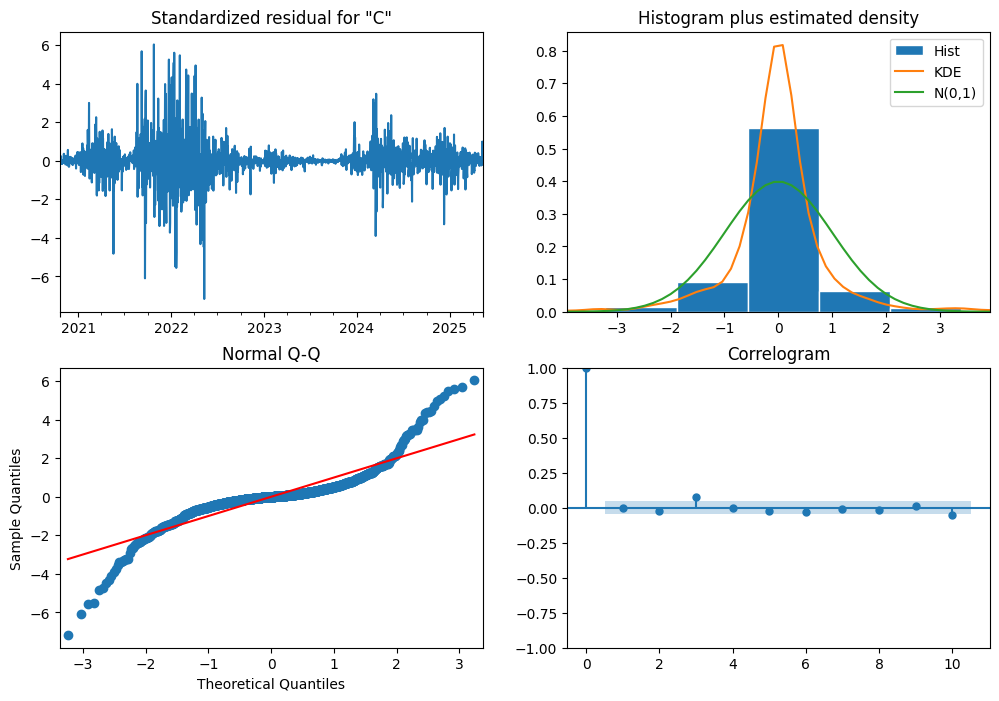

In [20]:
#tomaré la mejor configuración

sarimax_model = SARIMAX(
    y,
    exog=exog,
    order=(0, 1, 1),
    seasonal_order=(0, 0, 1, 7),
    trend='c'   # drift
)
sarimax_result = sarimax_model.fit()


print(sarimax_result.summary())
sarimax_result.plot_diagnostics(figsize=(12, 8))
plt.show()

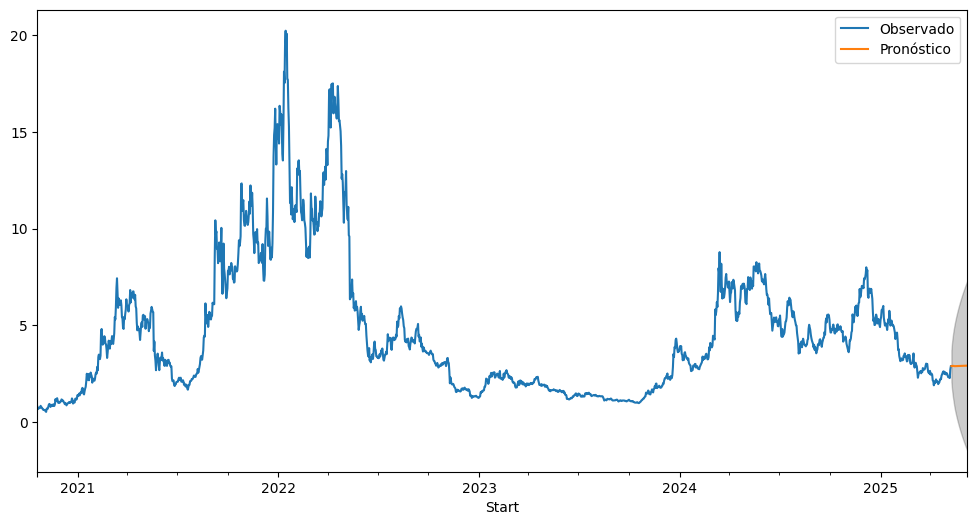

In [24]:
forecast = sarimax_result.get_forecast(steps=30, exog=[exog.iloc[-1]]*30)
forecast_ci = forecast.conf_int()

ax = y.plot(figsize=(12, 6), label='Observado')
forecast.predicted_mean.plot(ax=ax, label='Pronóstico')
ax.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='k', alpha=.2
)
plt.legend()
plt.show()


In [ ]:
# log return
df['Return'] = np.log(df['Close']).diff().dropna()

In [23]:
from arch import arch_model

returns = df['Return'].dropna()

# GARCH(1,1)
model = arch_model(returns, vol='GARCH', p=1, q=1, mean='Zero')  #asumimos 

result = model.fit(update_freq=10)
print(result.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2263.965621605785
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2263.97
Distribution:                  Normal   AIC:                          -4521.93
Method:            Maximum Likelihood   BIC:                          -4505.68
                                        No. Observations:                 1664
Date:                Mon, Jun 30 2025   Df Residuals:                     1664
Time:                        14:33:46   Df Model:                            0
                               Volatility Model                              
    

c:\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004373. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
# real vs pred
y_true = df['Close'].iloc[-len(y_pred):]
y_pred = sarimax_result.fittedvalues[-len(y_true):]  # O out-of-sample

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"SARIMAX MAE: {mae:.4f}")
print(f"SARIMAX RMSE: {rmse:.4f}")
print(f"SARIMAX R²: {r2:.4f}")


SARIMAX MAE: 0.0863
SARIMAX RMSE: 0.1137
SARIMAX R²: 0.7638


In [25]:
# Pronóstico de 14 días adelante
forecast = result.forecast(horizon=1000)
var_forecast = forecast.variance[-1:]
vol_forecast = np.sqrt(var_forecast.values).flatten()
print("Volatilidad esperada (desviación estándar diaria):")
print(vol_forecast)


Volatilidad esperada (desviación estándar diaria):
[0.06356779 0.06362137 0.06367383 0.0637252  0.0637755  0.06382476
 0.063873   0.06392023 0.06396649 0.06401179 0.06405615 0.0640996
 0.06414215 0.06418382 0.06422463 0.0642646  0.06430374 0.06434208
 0.06437963 0.06441641 0.06445243 0.06448772 0.06452227 0.06455612
 0.06458928 0.06462175 0.06465356 0.06468472 0.06471524 0.06474514
 0.06477442 0.06480311 0.06483121 0.06485874 0.0648857  0.06491212
 0.06493799 0.06496334 0.06498817 0.0650125  0.06503633 0.06505968
 0.06508255 0.06510495 0.0651269  0.0651484  0.06516947 0.06519011
 0.06521033 0.06523014 0.06524955 0.06526856 0.06528719 0.06530544
 0.06532332 0.06534083 0.065358   0.06537481 0.06539129 0.06540743
 0.06542324 0.06543874 0.06545392 0.06546879 0.06548336 0.06549764
 0.06551163 0.06552534 0.06553877 0.06555193 0.06556482 0.06557746
 0.06558983 0.06560196 0.06561385 0.06562549 0.0656369  0.06564808
 0.06565903 0.06566976 0.06568028 0.06569058 0.06570068 0.06571057
 0.06572027 

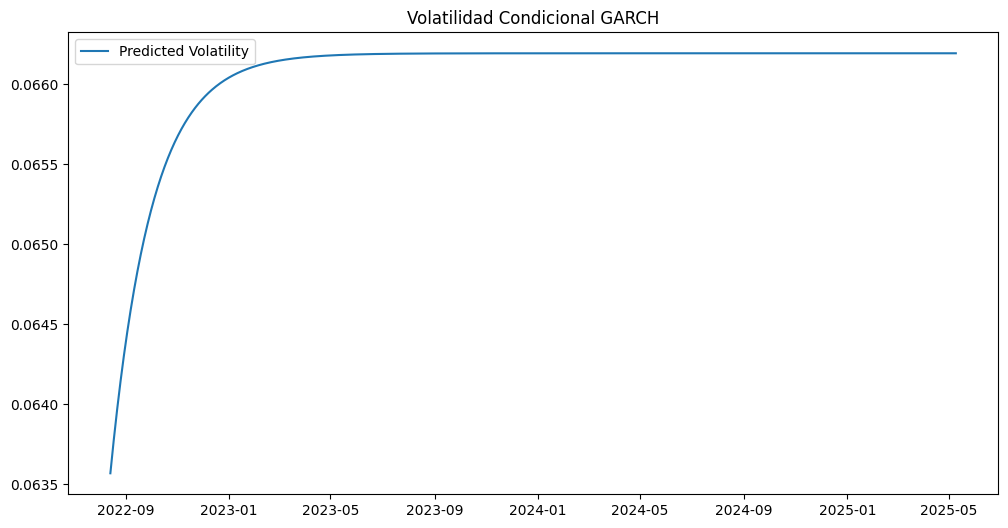

In [26]:
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(vol_forecast):], vol_forecast, label="Predicted Volatility")
plt.title("Volatilidad Condicional GARCH")
plt.legend()
plt.show()


In [ ]:
forecast = result.forecast(horizon=1000)


var_forecast = forecast.variance.iloc[-1, :14]  # shape: (14,)
vol_forecast = np.sqrt(var_forecast.values)     # shape: (14,)

# SARIMAX: pronóstico de 14 pasos con exog
sarimax_forecast = sarimax_result.get_forecast(steps=14, exog=future_exog)
sarimax_mean = sarimax_forecast.predicted_mean

print(vol_forecast.shape)   # (14,)
print(sarimax_mean.shape)   # (14,)


(14,)
(14,)


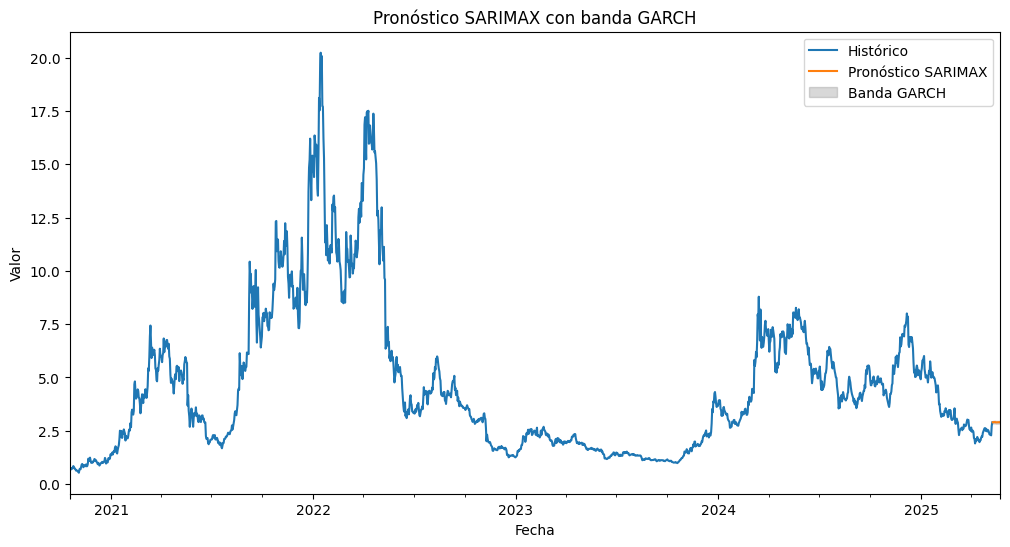

In [ ]:

upper = sarimax_mean + vol_forecast
lower = sarimax_mean - vol_forecast

plt.figure(figsize=(12, 6))

y.plot(label="Histórico")

sarimax_mean.plot(label="Pronóstico SARIMAX")

# Banda de volatilidad (GARCH)
plt.fill_between(
    sarimax_mean.index,
    lower,
    upper,
    color='gray',
    alpha=0.3,
    label='Banda GARCH'
)

plt.title("Pronóstico SARIMAX con banda GARCH")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()


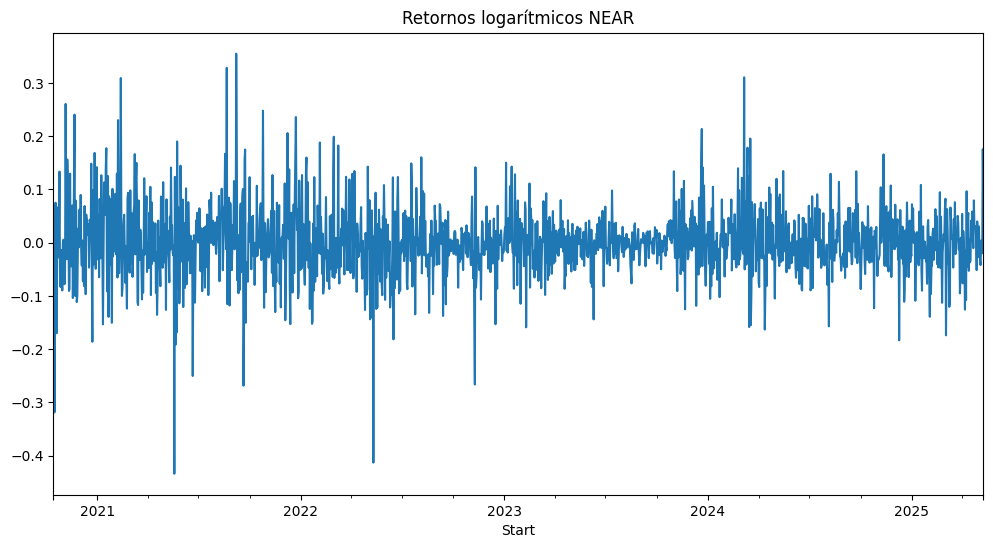

In [21]:
import matplotlib.pyplot as plt

df['Return'].plot(figsize=(12,6), title='Retornos logarítmicos NEAR')
plt.show()


# Experimento 5 - PROPHET

00:14:23 - cmdstanpy - INFO - Chain [1] start processing
00:14:23 - cmdstanpy - INFO - Chain [1] done processing


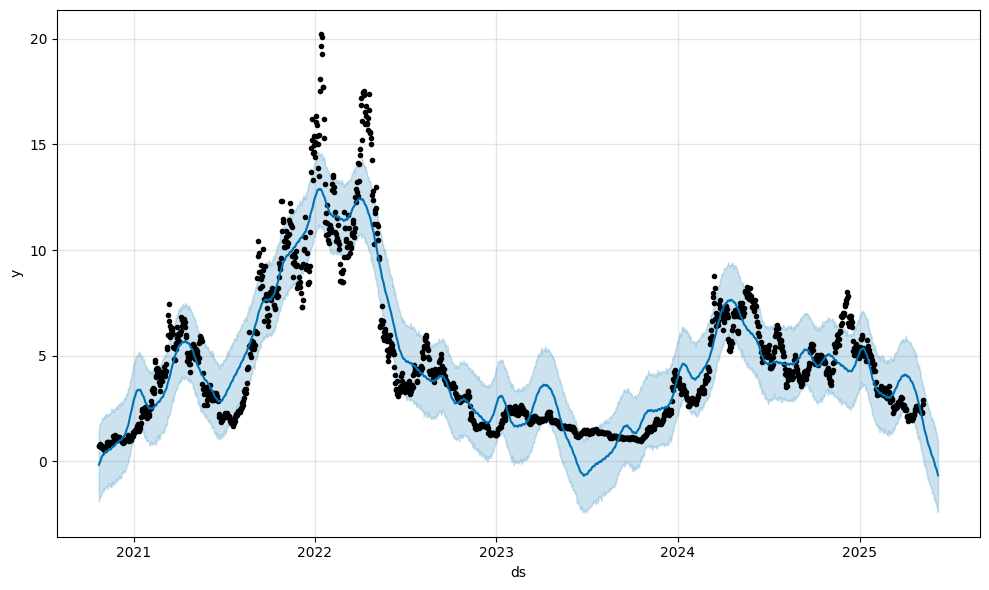

In [ ]:
df_prophet = df.copy()
df_prophet['ds'] = df_prophet.index  # DatetimeIndex
df_prophet['y'] = df_prophet['Close']

df_prophet = df_prophet[['ds', 'y']]

m = Prophet(daily_seasonality=True, yearly_seasonality=True)
m.fit(df_prophet)

# magia
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

fig = m.plot(forecast)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# forecast
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

print(forecast.columns)  

#2️ Junta real vs predicción SOLO para datos de test (últimos 30)
df_eval = df_prophet.set_index('ds').join(
    forecast.set_index('ds')[['yhat']], how='left'
)

# Toma solo periodo nuevo
df_eval = df_eval.tail(30)

y_true = df_eval['y']
y_pred = df_eval['yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
MAE: 0.9371
RMSE: 1.1501
R²: -23.1752


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

